# Drive Wheel Motor Torque Calculations

Determine whether the drive system wheels have enough surface traction to achieve the desired speed and acceleration for the robot weight and angle of incline.

## Initialisations

In [3]:
from math import *
import sympy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as pl
from matplotlib.ticker import FormatStrFormatter

# initialise drive wheel torque parameters
G_VW, N_DW, W_DW, R_W, V_max, t_a, a, C_rr, RF, u = \
sp.symbols(r"G_VW, N_DW, W_DW, R_W, V_max, t_a, \alpha, C_rr, RF, \mu")

## Force of Rolling Resistance

Rolling Resistance Force is the tractive force produced by the motor which turns the wheels forward, pushing against the surface. We will use the worse surface type the vehicle is expected to encounter in order to calculate this.

$${F_{RR} = G_{VW} \cdot 9.81 \cdot C_{rr}}$$

$F_{RR} =$ Force of rolling resistance $(N)$

$G_{VW} =$ Gross weight of vehicle $(kg)$

$C_{rr} =$ Surface friction for worst surface: dry wood $(0.010)$

| **Contact Surface** | **$C_{rr}$** |
| --- | --- |
| Concrete (good / fair / poor) | 0.010 / 0.015 / 0.020  |
| Asphalt (good / fair / poor)  | 0.012 / 0.017 / 0.022 |
| Wood (dry / dusty / wet) | 0.010 / 0.005 / 0.001 |
| Snow (2 inch / 4 inch) | 0.025 / 0.037  |
| Dirt (smooth / sandy) | 0.025 / 0.037  |
| Mud (firm / medium / soft)  | 0.037 / 0.090 / 0.150 |
| Grass (firm / soft) | 0.055 / 0.075  |
| Sand (firm / soft / dune) | 0.060 / 0.150 / 0.300 |

In [4]:
F_RR = sp.symbols("F_RR", cls=sp.Function)

In [5]:
F_RR = G_VW * 9.81 * C_rr
F_RR

9.81*C_rr*G_VW

In [6]:
# Convert F_RR into a numpy expression
F_RR_f = sp.lambdify((G_VW, C_rr), F_RR)
F_RR_f

<function _lambdifygenerated(G_VW, C_rr)>

## Force of Climbing Incline

Force of Grade Resistance is the Force required to move the vehicle up a desired incline. If vehicle is not required to climb an inclined surface, this value  becomes zero $(\sin(0) = 0)$.

$${F_{GR} = G_{VW} \cdot 9.81 \cdot \sin(\alpha)}$$

$F_{GR} =$ Force required to climb an incline (N)

$G_{VW} =$ Gross vehicle weight ($kg$)

$\alpha$ = maximum incline angle ($degrees$)

In [7]:
F_GR = sp.symbols("F_GR", cls=sp.Function)

In [8]:
F_GR = G_VW * 9.81 * sp.sin(a * sp.pi/180)
F_GR

9.81*G_VW*sin(pi*\alpha/180)

In [9]:
# Convert F_GR into a numpy expression
F_GR_f = sp.lambdify((G_VW, a), F_GR)
F_GR_f

<function _lambdifygenerated(G_VW, Dummy_23)>

## Force of Acceleration

Force required to accelerate vehicle from stationary position to maximum velocity in the required time. This Force does not depend on incline of surface.

$${F_{A} = \frac{G_{VW} \cdot V_{max}}{t_{a}}}$$

$F_{A} =$ Force required for acceleration $(N)$

$G_{VW} =$ Gross vehicle weight $(kg)$

$V_{max} =$ Maximum speed $(m/s)$

$t_{a} =$ Time required for maximum speed $(s)$

In [10]:
F_A = sp.symbols("F_A", cls=sp.Function)

In [11]:
F_A = G_VW * V_max / t_a
F_A

G_VW*V_max/t_a

In [12]:
F_A_f = sp.lambdify((G_VW, V_max, t_a), F_A)
F_A_f

<function _lambdifygenerated(G_VW, V_max, t_a)>

## Total Tractive Force

Total Tractive Force is the sum of the three Forces calculated in the previous sections. This is the cumulative Horizontal Force applied by the Drive Wheels to the ground.

$${F_{TT} = F_{RR} + F_{GR} + F_{A}}$$

$F_{TT} =$ Total tractive Force $(N)$

$F_{RR} =$ Force needed to overcome rolling resistance $(N)$

$F_{GR} =$ Grade Resistance Force required to climb an incline $(N)$

$F_{A} =$ Force required to accelerate to final velocity $(N)$

In [13]:
F_TT = sp.symbols("F_TT", cls=sp.Function)

In [14]:
F_TT = F_RR + F_GR + F_A
F_TT = F_TT.simplify()
F_TT

G_VW*(V_max + 9.81*t_a*(C_rr + sin(pi*\alpha/180)))/t_a

In [15]:
F_TT_f = sp.lambdify((G_VW, C_rr, a, V_max, t_a), F_TT)
F_TT_f

<function _lambdifygenerated(G_VW, C_rr, Dummy_24, V_max, t_a)>

## Motor Torque At Each Wheel

Wheel Motor Torque is the amount of Torque experienced at each Drive Wheel, based on wheel radius and accounting for internal drive mechanism losses.

$${T_{WM} = F_{TT} \cdot R_{W} \cdot RF}$$

$T_{WM} =$ Wheel Torque $(Nm)$

$F_{TT} =$ Total Tractive Force $(N)$

$R_{W} =$ Radius of wheel $(m)$

$RF =$ Resistance Factor. Accounts for drive component frictional losses. Typically 10 - 15%.

In [16]:
T_WM = sp.symbols("T_WM", cls=sp.Function)

In [17]:
T_WM = F_TT * R_W * RF
T_WM

G_VW*RF*R_W*(V_max + 9.81*t_a*(C_rr + sin(pi*\alpha/180)))/t_a

In [18]:
T_WM_f = sp.lambdify((G_VW, C_rr, a, V_max, t_a, R_W, RF), T_WM)
T_WM_f

<function _lambdifygenerated(G_VW, C_rr, Dummy_25, V_max, t_a, R_W, RF)>

## Maximum Tractive Torque

Verify vehicle can transmit required torque from Drive Wheels to the ground. This value depends on the number of Drive Wheels and hence the weight each Drive Wheel will experience.

$${M_{TT} = W_{DW} \cdot 9.81 \cdot \mu \cdot R_{W}}$$

$M_{TT} =$ Maximum Tractive Torque $(Nm)$

$W_{DW} =$ Weight (normal load) on drive wheel $(kg)$

$\mu =$ Frictional coefficient between the wheel and the ground (~0.7 for hard rubber on dry wood)

$R_{W} =$ Radius of wheel $(m)$

In [19]:
M_TT = sp.symbols("M_TT", cls=sp.Function)

In [20]:
M_TT = W_DW * 9.81 * u * R_W
M_TT

9.81*R_W*W_DW*\mu

In [21]:
M_TT_f = sp.lambdify((W_DW, R_W, u), M_TT)
M_TT_f

<function _lambdifygenerated(W_DW, R_W, Dummy_26)>

## Sum of Maximum Tractive Torques

Determine limit for when wheel slippage will to occur by summing the Maximum Tractive Torques $(SUM\_{M_{TT}})$ for all Drive Wheels $(N_{DW})$.

$${SUM\_M_{TT} = M_{TT} \cdot N_{DW}}$$

$SUM\_M_{TT} =$ Sum of Maximum Tractive Torques $(Nm)$

$M_{TT} =$ Maximum Tractive Torque $(Nm)$

$N_{DW} =$ Number of drive wheels$

In [22]:
SUM_M_TT = sp.symbols("SUM_M_TT", cls=sp.Function)

In [23]:
SUM_M_TT = M_TT * N_DW
SUM_M_TT

9.81*N_DW*R_W*W_DW*\mu

In [24]:
SUM_M_TT_f = sp.lambdify((W_DW, R_W, u, N_DW), SUM_M_TT)
SUM_M_TT_f

<function _lambdifygenerated(W_DW, R_W, Dummy_27, N_DW)>

## Define Parameters

Set acceptable values for the Drive Wheel Torque Parameters

In [25]:
G_VW = 20 # Gross vehicle weight (kg)
N_DW = 6 # Number of drive wheels
W_DW = 10/3 # (20/6) Weight on each drive wheel (kg)
R_W = 0.0508 # Radius of wheel (m)
V_max = 0.4 # Desired top speed (m/s)
t_a = 2 # Desired acceleration time  (s)
a = 35 # Maximum incline angle (degrees)
C_rr = 0.01 # Worst surface friction (dry wood)
RF = 1.15 # Resistance Factor (10 - 15%)
u = 0.7 # Frictional coefficient between the wheel and the ground (hard rubber on dry wood)

## Perform Calculations

Calculate $F_{RR}$ Force of rolling resistance $(N)$

In [26]:
F_RR_f(G_VW, C_rr)

1.9620000000000002

Calculate $F_{GR}$ Grade Resistance Force required to climb an incline $(N)$

In [27]:
F_GR_f(G_VW, a)

112.53569681207524

Calculate $F_{A}$ Force required to accelerate to final velocity $(N)$

In [28]:
F_A_f(G_VW, V_max, t_a)

4.0

Calculate $F_{TT}$ Total Tractive Force $(N)$

In [29]:
F_TT_f(G_VW, C_rr, a, V_max, t_a)

118.49769681207525

Calculate $T_{WM}$ Wheel Torque $(Nm)$

In [30]:
T_WM_f(G_VW, C_rr, a, V_max, t_a, R_W, RF)

6.922635447761435

Calculate $M_{TT}$ Maximum Tractive Torque $(Nm)$

In [31]:
M_TT_f(W_DW, R_W, u)

1.162812

Calculate $SUM\_M_{TT}$ Sum of Maximum Tractive Torques $(Nm)$

In [32]:
SUM_M_TT_f(W_DW, R_W, u, N_DW)

6.976872

## Parameters Check to Avoid Slippage

$$T_{WM} \leq SUM\_M_{TT}$$

The Wheel Motor Torque $(T_{WM})$ must be less than or equal to the sum of the Maximum Tractive Torques $(SUM\_M_{TT})$ to avoid slippage of the Drive Wheels.

In [33]:
wheel_motor_torque = T_WM_f(G_VW, C_rr, a, V_max, t_a, R_W, RF)
wheel_motor_torque

6.922635447761435

In [34]:
sum_max_tractive_torques = SUM_M_TT_f(W_DW, R_W, u, N_DW)
sum_max_tractive_torques

6.976872

In [35]:
if (wheel_motor_torque <= sum_max_tractive_torques):
    print("Motor Torque Parameters are viable")
else:
    print("Motor Torque Parameters are NOT viable and slippage will occur.")

Motor Torque Parameters are viable


## Graphing Parameter Variations
### Param 1: $G_{VW}$ Gross vehicle weight 10 - 25 kg

In [36]:
G_VW_x_vals = np.linspace(10, 25, 100)
G_VW_y_vals = T_WM_f(G_VW_x_vals, C_rr, a, V_max, t_a, R_W, RF)

In [37]:
# create data points for when slippage will occur
SUM_M_TT_x_vals = np.linspace(0, 50, 10)
SUM_M_TT_y_vals = np.full((len(SUM_M_TT_x_vals)), SUM_M_TT_f(W_DW, R_W, u, N_DW))

### Param 2: $\alpha$ Maximum incline angle 10 - 50 degrees

In [38]:
a_x_vals = np.linspace(10, 50, 100)
a_y_vals = T_WM_f(G_VW, C_rr, a_x_vals, V_max, t_a, R_W, RF)

### Param 3: $V_{max}$ Desired top speed 0.1 - 1.0 m/s

In [39]:
V_max_x_vals = np.linspace(0.1, 1, 100)
V_max_y_vals = T_WM_f(G_VW, C_rr, a, V_max_x_vals, t_a, R_W, RF)

### Generate Graphs

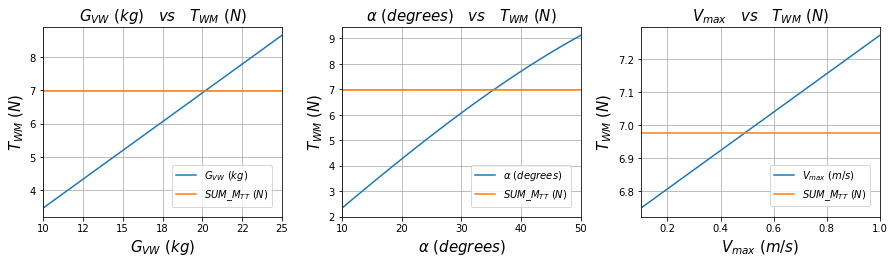

In [42]:
fig, (ax1, ax2, ax3) = pl.subplots(1, 3, gridspec_kw={"wspace":0.25,"width_ratios": [1,1,1]}, figsize=(15,3.5))

# create gross vehicle weight plot
ax1.plot(G_VW_x_vals, G_VW_y_vals, label=r"$G_{VW}~(kg)$")
ax1.plot(SUM_M_TT_x_vals, SUM_M_TT_y_vals, label=r"$SUM\_M_{TT}~(N)$")
ax1.set_title(r"$G_{VW}~(kg)~~~vs~~~T_{WM}~(N)$", fontsize=15)
ax1.set_xlim(10, 25)
ax1.xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax1.set_xlabel(r"$G_{VW}~(kg)$", fontsize=15)
ax1.set_ylabel(r"$T_{WM}~(N)$", fontsize=15)
ax1.legend(bbox_to_anchor=(0.98, 0.30), fontsize=10)
ax1.grid()

# create maximum incline angle plot
ax2.plot(a_x_vals, a_y_vals, label=r"$\alpha~(degrees)$")
ax2.plot(SUM_M_TT_x_vals, SUM_M_TT_y_vals, label=r"$SUM\_M_{TT}~(N)$")
ax2.set_title(r"$\alpha~(degrees)~~~vs~~~T_{WM}~(N)$", fontsize=15)
ax2.set_xlim(10, 50)
ax2.xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax2.set_xlabel(r"$\alpha~(degrees)$", fontsize=15)
ax2.set_ylabel(r"$T_{WM}~(N)$", fontsize=15)
ax2.legend(bbox_to_anchor=(0.98, 0.30), fontsize=10)
ax2.grid()

# create desired top speed plot
ax3.plot(V_max_x_vals, V_max_y_vals, label=r"$V_{max}~(m/s)$")
ax3.plot(SUM_M_TT_x_vals, SUM_M_TT_y_vals, label=r"$SUM\_M_{TT}~(N)$")
ax3.set_title(r"$V_{max}~~~vs~~~T_{WM}~(N)$", fontsize=15)
ax3.set_xlim(0.1, 1)
ax3.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
ax3.set_xlabel(r"$V_{max}~(m/s)$", fontsize=15)
ax3.set_ylabel(r"$T_{WM}~(N)$", fontsize=15)
ax3.legend(bbox_to_anchor=(0.98, 0.30), fontsize=10)
ax3.grid()

pl.show()

Graph of robot weight (kg), angle of incline (degrees), robot top speed (m/s) vs Wheel Motor Torque (N). In each case, once the Wheel Motor Torque (N) crosses the sum of the Maximum Tractive Torques (N), represented by the horizontal line, wheel slippage will occur.

- Graph 1: robot weight varied (10 – 25 kg), angle of incline fixed (35 degrees), robot top speed fixed (0.4 m/s)
- Graph 2: angle of incline varied (10 – 50 degrees), robot weight fixed (20 kg), robot top speed fixed (0.4 m/s)
- Graph 3: robot top speed varied (0.1 – 1.0 m/s), robot weight fixed (20kg), angle of incline fixed (35 degrees)